# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc
from pathlib import Path

#### One damped forced pendulum with a constant forcing

In [ ]:
def create_synthetic_damped_forced_pendulum(A: float, omega: float, b: float, L: float, g: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    b (float): Damping coefficient.
    L (float): Length of the pendulum.
    g (float): Acceleration due to gravity.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - (b / L) * omega_t - (g / L) * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [3]:
A = 1.0
omega = 3.0
b = 0.5
L = 5.0
g = 9.81
theta0 = 0.1  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, b, L, g, theta0, omega0, t)

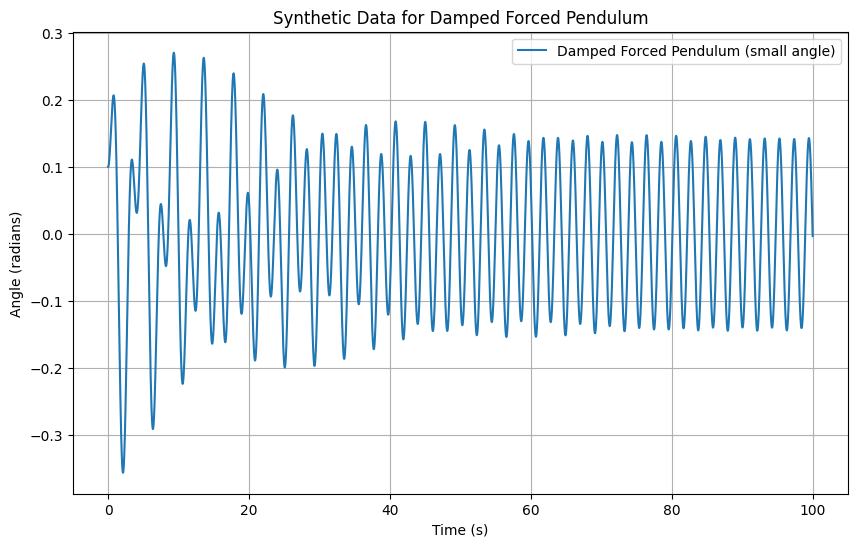

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [7]:
def create_trapezoidal_forcing(t: np.ndarray, start_value: float, end_value: float, proportions: list[float], N_time_steps: int) -> np.ndarray:
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

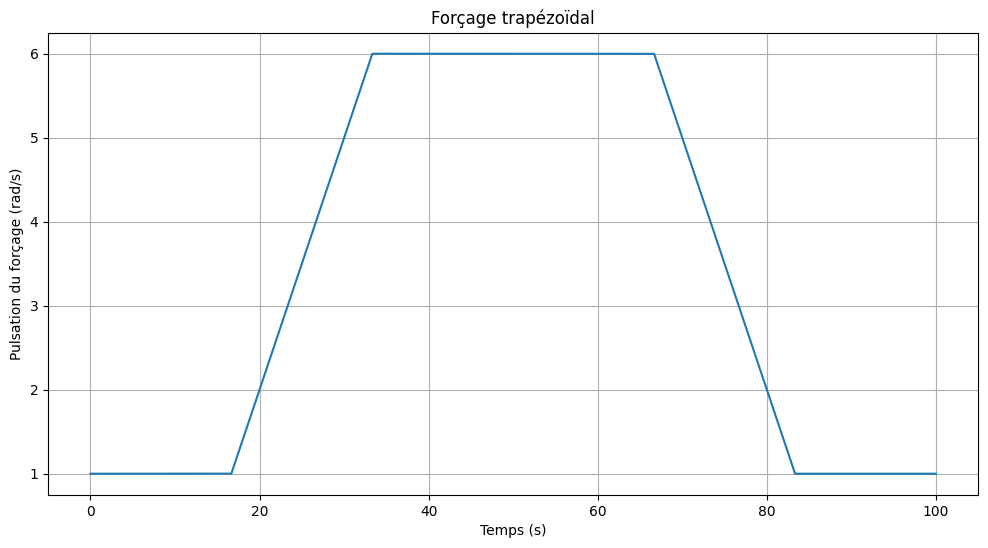

In [8]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Temps (s)')
plt.ylabel('Pulsation du forçage (rad/s)')
plt.title('Forçage trapézoïdal')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [9]:
def create_synthetic_damped_forced_pendulum(A_array: np.ndarray, omega_array: np.ndarray, b: float, L: float, g: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (numpy array): Amplitude of the forcing term (time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        b (float): Damping coefficient.
        L (float): Length of the pendulum.
        g (float): Acceleration due to gravity.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if len(A_array) != len(t):
        raise ValueError("If A is an array, it must have the same length as t")


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - (b / L) * omega_t - (g / L) * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [41]:
# Time array
N_time_steps = 1000
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
A_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=10.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
omega_value = 1.0
omega_array = np.ones(N_time_steps) * omega_value
# Parameters
b = 0.1
L = 2.0
g = 9.81
theta0 = 0.1
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A_array, omega_array, b, L, g, theta0, omega0, t)

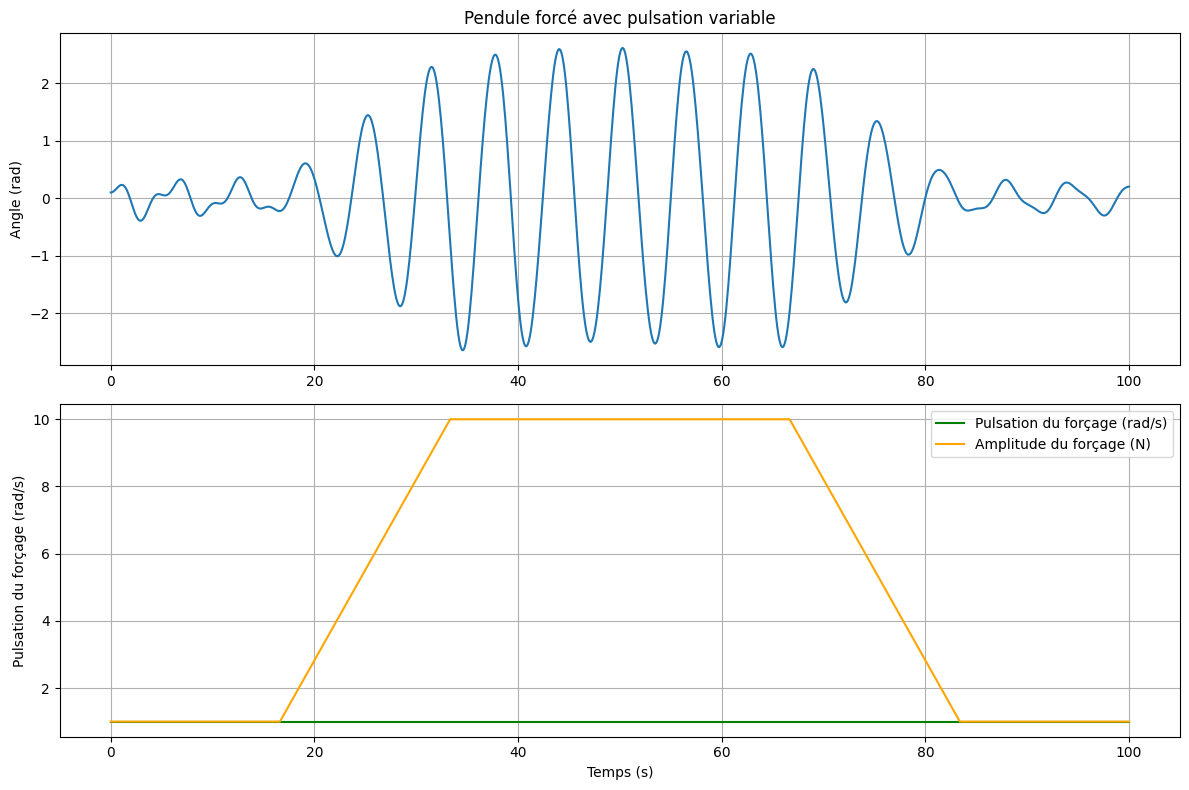

In [42]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Pendule forcé avec pulsation variable')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Pulsation du forçage (rad/s)')
ax2.plot(t, A_array, color='orange', label='Amplitude du forçage (N)')
ax2.set_ylabel('Pulsation du forçage (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* g: fixed
* theta0: fixed
* omega0: fixed
* L: varying randomly
* b: varying randomly
* omega_forcing: choosen among a discret number


In [151]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        L_range: tuple, 
        b_range: tuple, 
        trapezoidal_forcing_values: dict,
        A_value: float | None = 1.0,
        omega_value: float | None = 1.0,
        g: int = 9.81, 
        theta0: float = 0.5, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        L_range (tuple): Tuple defining the range of lengths (min, max).
        b_range (tuple): Tuple defining the range of damping coefficients (min, max).
        omega_forcing_values (dict): dictionary of args for the forcing parameters.
    
    Parameters:
        A_value (float): Amplitude of the forcing term (constant).
        g (float): Acceleration due to gravity.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    assert (A_value is not None) ^ (omega_value is not None), "Either A_value or omega_value must be provided as constant."

    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        trap_start, trap_end = 1.0, 0.0
        while trap_start >= trap_end:
            trap_start = np.random.uniform(*trapezoidal_forcing_values["start_value"])
            trap_end = np.random.uniform(*trapezoidal_forcing_values["end_value"])
        proportions = [np.random.uniform(*trapezoidal_forcing_values["proportions"][a]) for a in range(4)]
        trap_forcing_values_sampled = {
            "start_value": trap_start,
            "end_value": trap_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        if omega_value is not None:
            A_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            omega_forcing = np.ones(n_timestep) * omega_value
        else:
            omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            A_forcing = np.ones(n_timestep) * A_value

        # Randomly sample L and b within their respective ranges
        L = np.random.uniform(L_range[0], L_range[1])
        b = np.random.uniform(b_range[0], b_range[1])
        
        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_forcing, omega_forcing, b, L, g, theta0, omega0, t)
        
        # Store the parameters and the resulting angle array
        sample = {
            'L': L,
            'b': b,
            'forcing': omega_forcing if omega_value is None else A_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [152]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
trapezoidal_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

b_range = (0.01, 5.0)
L_range = (0.01, 10.0)
N_samples = 10000
N_time_steps = 200
max_time = 100.0

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    L_range=L_range,
    b_range=b_range,
    trapezoidal_forcing_values=trapezoidal_forcing_ranges,
    A_value=None,
    omega_value=1.0
)

100%|██████████| 10000/10000 [03:58<00:00, 41.92it/s]


In [153]:
len(dataset)

10000

In [154]:
path = Path().absolute().parent / "data/raw/synthetic_damped_forced_pendulum_dataset.npy"
np.save(path, dataset)

In [155]:
dataset[0]

{'L': 7.559225747226117,
 'b': 1.1766383854876417,
 'forcing': array([1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.54084266, 1.54084266, 1.54084266, 1.54084266, 1.54084266,
        1.66661917, 1.79239569, 1.91817221, 2.04394872, 2.16972524,
        2.29550175, 2.42127827, 2.54705479, 2.6728313 , 2.79860782,
        2.92438433, 3.05016085, 3.17593737, 3.30171388, 3.4274904 ,
        3.55326691, 3.67904343, 3.80481995, 3.93059646, 4.05637298,
        4.18214949, 4.30792601, 4.43370253, 4.55947904

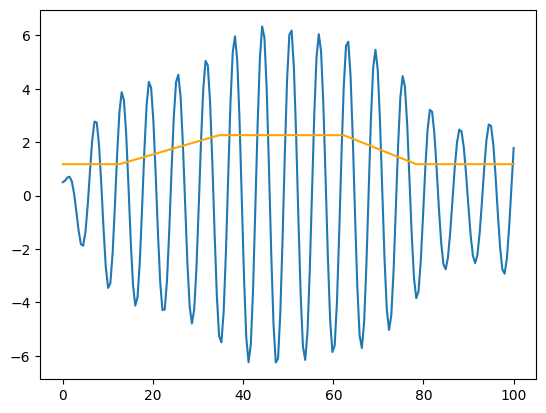

In [156]:
id_to_plot = 8
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['angle'])
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [157]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [158]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['forcing'], dtype=torch.float32)
        params = torch.tensor([sample['L'], sample['b']], dtype=torch.float32)
        return observations, questions, params

In [159]:
split_ratio = [0.6, 0.2, 0.2]  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [160]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 6000
Validation size: 2000
Test size: 2000
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [161]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

#### Scinet network

In [162]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [163]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:
    # prediction_loss = nn.MSELoss(reduction='none')(possible_answer, a_corr)
    # kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).unsqueeze(-1)
    # total_loss = prediction_loss + beta * kld_loss
    # return torch.mean(total_loss)

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [164]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [165]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = Path().absolute().parent / "results/model_params/checkpoints" / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [166]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = Path().absolute().parent / "results/figures" / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [168]:
### SCINET architecture
TIMESTEPS = N_time_steps
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = [500, 100] # [500, 100, 100]
M_LATENT_SIZE = 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = [500, 500] # [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = 50
BATCH_SIZE_VALID = 50
FIRST_LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5     # if needed
KLD_BETA = 0.0003

### Train parameters
NUM_EPOCHS = 150
ES_PATIENCE = 10
ES_MIN_DELTA = 5e-4
GC_MAX_NORM = 1.0
LRS_FACTOR = 0.66
LRS_PATIENCE = 5
LRS_MIN_LR = 1e-7
LRS_MIN_DELTA = 1e-4

In [169]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [170]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = Path().absolute().parent / "results/model_params" / "pendulum_scinet_final.pth"
torch.save(pendulum_net.state_dict(), path)

------training on cuda-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  12.903811        |  2048.914175  12.289136       |    1.788658       


2/150                 |  1.174114         |  692.798620   0.966275        |    0.776906       


3/150                 |  18269.726323     |  134070.292270 18229.505023    |    0.641105       


4/150                 |  0.590540         |  354.997520   0.484041        |    0.756578       


5/150                 |  0.497321         |  305.136921   0.405780        |    0.572996       


6/150                 |  0.530982         |  266.019811   0.451176        |    0.343049       


7/150                 |  0.391821         |  232.941099   0.321939        |    0.362762       


8/150                 |  0.399900         |  215.514478   0.335246        |    0.336650       


9/150                 |  0.431488         |  193.731092   0.373369        |    0.378198       


10/150                |  0.399226         |  198.603049   0.339645        |    0.299177       


11/150                |  0.324171         |  183.744922   0.269047        |    0.347145       


12/150                |  0.315534         |  167.906483   0.265162        |    0.519085       


13/150                |  0.318391         |  162.042472   0.269778        |    0.314100       


14/150                |  0.301298         |  150.846651   0.256044        |    0.226895       


15/150                |  0.332552         |  150.192783   0.287494        |    0.523050       


16/150                |  0.288696         |  152.895496   0.242828        |    0.207162       


17/150                |  0.248344         |  136.326494   0.207446        |    0.183413       


18/150                |  0.242453         |  130.539751   0.203291        |    0.216603       


19/150                |  0.238252         |  126.883647   0.200187        |    0.145221       


20/150                |  0.210402         |  116.890777   0.175335        |    0.244838       


21/150                |  0.274459         |  113.316050   0.240464        |    0.217790       


22/150                |  0.241301         |  117.275412   0.206118        |    0.151798       


23/150                |  0.250602         |  118.174284   0.215150        |    0.181825       


24/150                |  0.203326         |  115.953027   0.168540        |    0.153337       
Reduced learning rate from 5.00e-04 to 3.30e-04


25/150                |  0.162414         |  109.536106   0.129554        |    0.158331       


26/150                |  0.172370         |  104.258464   0.141092        |    0.118071       


27/150                |  0.148779         |  99.272691    0.118997        |    0.135688       


28/150                |  0.147675         |  97.982154    0.118281        |    0.121596       


29/150                |  0.146891         |  93.062209    0.118972        |    0.113851       


30/150                |  0.131458         |  90.329804    0.104359        |    0.095572       


31/150                |  0.117828         |  87.301454    0.091638        |    0.119310       


32/150                |  0.115623         |  81.854289    0.091067        |    0.097950       


33/150                |  0.131519         |  79.362281    0.107710        |    0.106077       


34/150                |  0.119364         |  78.402603    0.095843        |    0.128493       


35/150                |  0.125702         |  77.562774    0.102433        |    0.160060       
Reduced learning rate from 3.30e-04 to 2.18e-04


36/150                |  0.093208         |  76.674926    0.070205        |    0.084225       


37/150                |  0.087575         |  74.999324    0.065076        |    0.079640       


38/150                |  0.090337         |  72.665196    0.068538        |    0.089884       


39/150                |  0.086808         |  70.240754    0.065736        |    0.086115       


40/150                |  0.080735         |  69.418062    0.059909        |    0.087801       


41/150                |  0.077291         |  66.710314    0.057278        |    0.075364       


42/150                |  0.083456         |  65.140304    0.063914        |    0.068681       


43/150                |  0.079408         |  63.229282    0.060439        |    0.081886       


44/150                |  0.077770         |  62.881146    0.058906        |    0.083393       


45/150                |  0.071852         |  61.695513    0.053344        |    0.060685       


46/150                |  0.074986         |  60.752412    0.056760        |    0.065223       


47/150                |  0.079294         |  60.374281    0.061182        |    0.071310       


48/150                |  0.068759         |  59.579921    0.050885        |    0.063435       


49/150                |  0.067893         |  58.662736    0.050295        |    0.072841       


50/150                |  0.071872         |  58.159494    0.054424        |    0.061121       
Reduced learning rate from 2.18e-04 to 1.44e-04


51/150                |  0.057755         |  56.978619    0.040662        |    0.067356       


52/150                |  0.057044         |  55.981210    0.040250        |    0.057998       


53/150                |  0.056201         |  54.782048    0.039767        |    0.056402       


54/150                |  0.051927         |  53.797193    0.035788        |    0.054799       


55/150                |  0.052193         |  52.303290    0.036502        |    0.047805       


56/150                |  0.053031         |  51.753733    0.037505        |    0.085028       


57/150                |  0.054874         |  51.331373    0.039475        |    0.057321       


58/150                |  0.053393         |  50.891985    0.038125        |    0.062539       


59/150                |  0.049432         |  50.094921    0.034403        |    0.058294       


60/150                |  0.050722         |  49.621459    0.035836        |    0.054463       
Reduced learning rate from 1.44e-04 to 9.49e-05


61/150                |  0.046110         |  49.127751    0.031372        |    0.046082       


62/150                |  0.041710         |  48.386545    0.027194        |    0.046672       


63/150                |  0.040300         |  47.542605    0.026037        |    0.042703       


64/150                |  0.043276         |  47.003658    0.029175        |    0.047127       


65/150                |  0.041143         |  46.327987    0.027245        |    0.048353       


66/150                |  0.039987         |  45.830410    0.026238        |    0.047395       


67/150                |  0.038446         |  45.187509    0.024889        |    0.048174       


68/150                |  0.038212         |  44.780811    0.024777        |    0.041897       


69/150                |  0.038798         |  44.305355    0.025507        |    0.045320       


70/150                |  0.039001         |  44.016408    0.025796        |    0.042585       


71/150                |  0.037704         |  43.451777    0.024669        |    0.041162       


72/150                |  0.037820         |  43.095405    0.024891        |    0.040573       


73/150                |  0.036293         |  42.693372    0.023485        |    0.047227       


74/150                |  0.038495         |  42.279280    0.025811        |    0.041296       


75/150                |  0.036409         |  41.889216    0.023842        |    0.041306       


76/150                |  0.035612         |  41.467155    0.023172        |    0.041350       


77/150                |  0.037114         |  41.021212    0.024808        |    0.046412       
Reduced learning rate from 9.49e-05 to 6.26e-05


78/150                |  0.033502         |  40.757162    0.021274        |    0.037543       


79/150                |  0.032074         |  40.356763    0.019967        |    0.037909       


80/150                |  0.032099         |  39.996760    0.020100        |    0.036923       


81/150                |  0.031747         |  39.642417    0.019855        |    0.037503       


82/150                |  0.034030         |  39.384917    0.022214        |    0.034616       


83/150                |  0.031042         |  39.178777    0.019288        |    0.036906       


84/150                |  0.031165         |  38.814183    0.019520        |    0.035707       


85/150                |  0.030755         |  38.526856    0.019197        |    0.035650       


86/150                |  0.031282         |  38.225828    0.019814        |    0.034883       


87/150                |  0.030481         |  38.022472    0.019074        |    0.034548       
Reduced learning rate from 6.26e-05 to 4.13e-05


88/150                |  0.028593         |  37.756304    0.017266        |    0.034454       


89/150                |  0.028403         |  37.414877    0.017179        |    0.033754       


90/150                |  0.028014         |  37.120642    0.016878        |    0.033760       


91/150                |  0.028064         |  36.956917    0.016977        |    0.034160       


92/150                |  0.028012         |  36.728229    0.016993        |    0.033245       


93/150                |  0.027863         |  36.468232    0.016923        |    0.033637       


94/150                |  0.027613         |  36.259819    0.016735        |    0.032901       


95/150                |  0.027387         |  35.963171    0.016598        |    0.034788       


96/150                |  0.027332         |  35.830726    0.016583        |    0.032756       


97/150                |  0.027079         |  35.650308    0.016384        |    0.032754       


98/150                |  0.027221         |  35.486525    0.016575        |    0.033294       


99/150                |  0.026894         |  35.223640    0.016327        |    0.032185       


100/150               |  0.026574         |  35.073067    0.016053        |    0.031814       


101/150               |  0.026933         |  34.897702    0.016463        |    0.032527       


102/150               |  0.026386         |  34.653038    0.015990        |    0.032920       


103/150               |  0.026568         |  34.536181    0.016207        |    0.032305       


104/150               |  0.026104         |  34.381419    0.015790        |    0.032320       


105/150               |  0.026222         |  34.181822    0.015967        |    0.032863       
Reduced learning rate from 4.13e-05 to 2.73e-05


106/150               |  0.025315         |  34.094567    0.015087        |    0.030936       


107/150               |  0.025254         |  33.904255    0.015082        |    0.030535       


108/150               |  0.025009         |  33.749936    0.014884        |    0.031321       


109/150               |  0.024875         |  33.662622    0.014776        |    0.031022       


110/150               |  0.024906         |  33.580393    0.014831        |    0.031122       


111/150               |  0.024883         |  33.421941    0.014856        |    0.031297       


112/150               |  0.024769         |  33.378355    0.014755        |    0.030686       
Reduced learning rate from 2.73e-05 to 1.80e-05


113/150               |  0.024211         |  33.246278    0.014237        |    0.029948       


114/150               |  0.024203         |  33.105398    0.014271        |    0.030149       


115/150               |  0.024053         |  33.036739    0.014142        |    0.029809       


116/150               |  0.024025         |  32.938045    0.014143        |    0.029520       


117/150               |  0.023820         |  32.843837    0.013967        |    0.029559       


118/150               |  0.023735         |  32.758047    0.013907        |    0.029731       


119/150               |  0.023790         |  32.666839    0.013990        |    0.029815       


120/150               |  0.023699         |  32.571464    0.013927        |    0.029588       


121/150               |  0.023565         |  32.478624    0.013821        |    0.029690       
Reduced learning rate from 1.80e-05 to 1.19e-05


122/150               |  0.023293         |  32.399346    0.013573        |    0.029378       


123/150               |  0.023254         |  32.319243    0.013558        |    0.029264       


124/150               |  0.023109         |  32.242096    0.013437        |    0.029179       


125/150               |  0.023191         |  32.184502    0.013535        |    0.029441       


126/150               |  0.023179         |  32.125839    0.013541        |    0.029453       


127/150               |  0.023087         |  32.098221    0.013458        |    0.028849       


128/150               |  0.023030         |  31.997525    0.013430        |    0.029124       


129/150               |  0.022947         |  31.925257    0.013369        |    0.029352       


130/150               |  0.022903         |  31.868173    0.013343        |    0.029117       


131/150               |  0.022926         |  31.797496    0.013387        |    0.029015       


132/150               |  0.022901         |  31.764256    0.013372        |    0.029061       
Reduced learning rate from 1.19e-05 to 7.84e-06


133/150               |  0.022700         |  31.710787    0.013187        |    0.028849       


134/150               |  0.022665         |  31.657069    0.013168        |    0.028865       


135/150               |  0.022660         |  31.612910    0.013176        |    0.029009       


136/150               |  0.022581         |  31.550179    0.013116        |    0.028902       


137/150               |  0.022554         |  31.508430    0.013102        |    0.028871       
Reduced learning rate from 7.84e-06 to 5.18e-06


138/150               |  0.022412         |  31.462130    0.012973        |    0.028680       


139/150               |  0.022391         |  31.427727    0.012962        |    0.028649       


140/150               |  0.022384         |  31.398532    0.012964        |    0.028558       


141/150               |  0.022343         |  31.363296    0.012934        |    0.028679       


142/150               |  0.022323         |  31.330938    0.012924        |    0.028658       


143/150               |  0.022325         |  31.305667    0.012933        |    0.028530       


144/150               |  0.022312         |  31.265182    0.012933        |    0.028533       


145/150               |  0.022264         |  31.243556    0.012891        |    0.028581       
Reduced learning rate from 5.18e-06 to 3.42e-06


146/150               |  0.022181         |  31.206105    0.012819        |    0.028469       


147/150               |  0.022194         |  31.189897    0.012837        |    0.028417       


148/150               |  0.022176         |  31.172366    0.012825        |    0.028463       


149/150               |  0.022156         |  31.136068    0.012815        |    0.028504       


150/150               |  0.022158         |  31.131205    0.012819        |    0.028542       


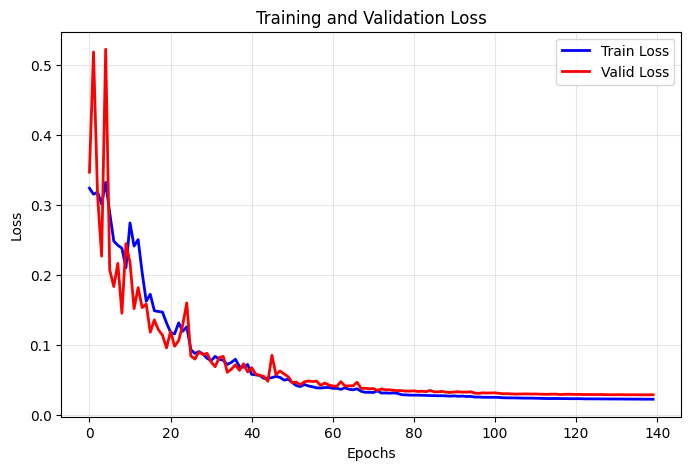

In [172]:
plot_history(history['train_loss'][10:], history['valid_loss'][10:])

#### Test pendulumenet

In [180]:
sample_idx = 576  # Change this index to test different samples

In [181]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

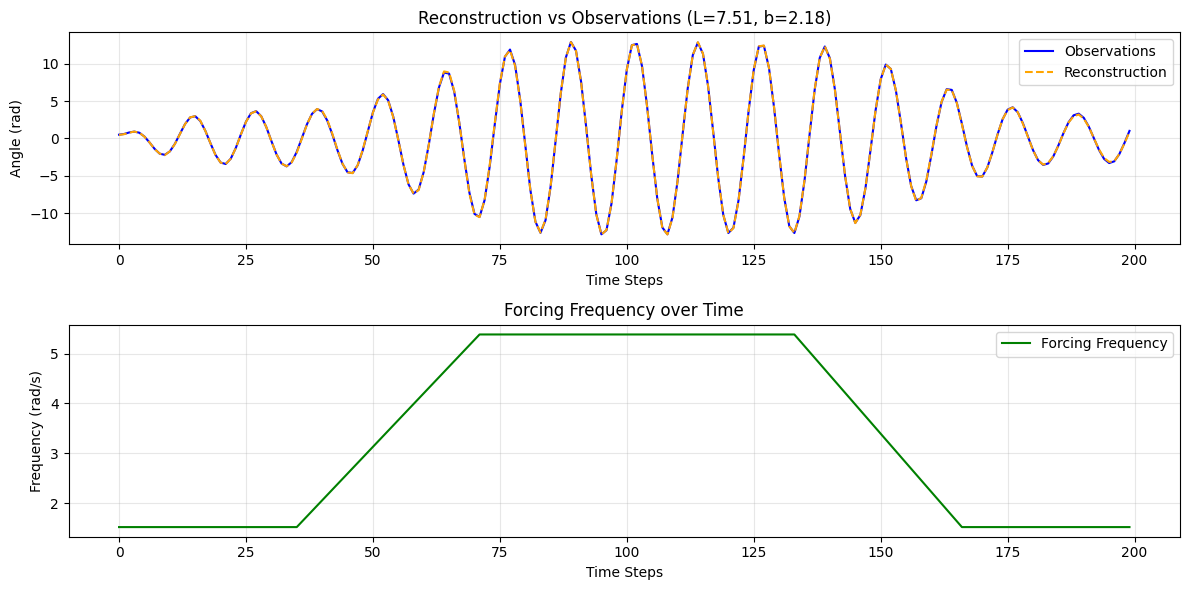

In [182]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (L={L:.2f}, b={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

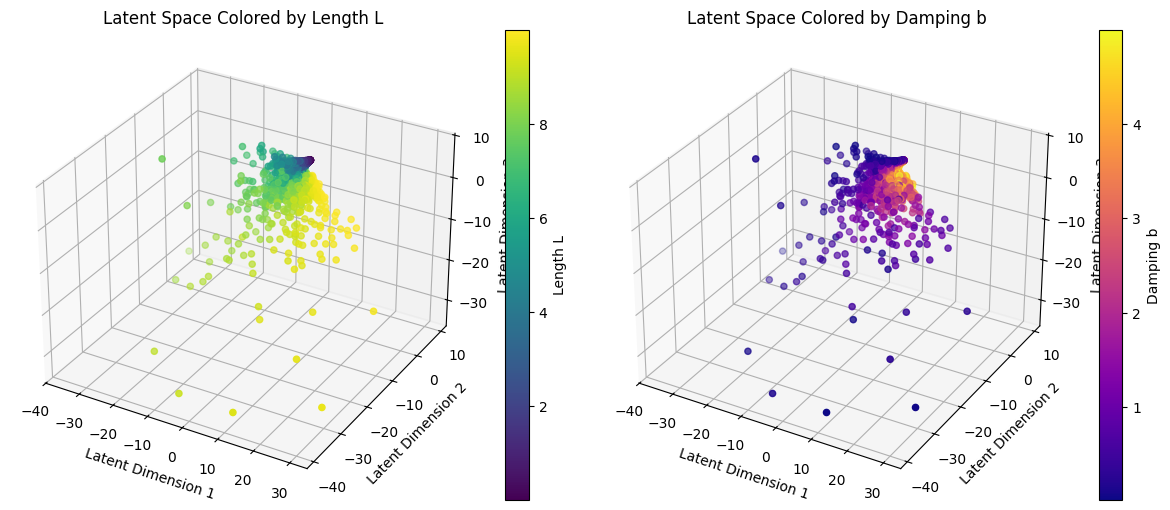

In [176]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Length L')
ax.set_title('Latent Space Colored by Length L')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping b')
ax.set_title('Latent Space Colored by Damping b')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.tight_layout()
plt.show()